## 任务描述：

### 如何根据据图像的视觉内容为图像赋予一个语义类别是**图像分类**的目标，也是图像检索、图像内容分析和目标识别等问题的基础。

### 本实践旨在通过一个美食分类的案列，让大家理解和掌握如何使用飞桨动态图搭建一个**卷积神经网络**。

### 特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。

In [49]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
from PIL import ImageEnhance
import paddle
from paddle import fluid
import matplotlib.pyplot as plt 
import paddle.vision.transforms as T  
import paddle.nn as nn
import paddle.nn.functional as F
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# device = paddle.set_device('cpu')
device = paddle.set_device('gpu')
device


Place(gpu:0)

In [50]:
paddle.__version__

'2.5.2'

In [51]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 64, 64],                                #输入图片的shape
    "class_dim": 5,                                          #分类数
    "src_path":"data/foods.zip",                    #原始数据集路径
    "target_path":"data/",                     #要解压的路径
    "train_list_path": "data/train.txt",       #train.txt路径
    "eval_list_path": "data/eval.txt",         #eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 30,                                          #训练轮数
    "train_batch_size": 64,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.01                                          #超参数学习率
    } 
}

In [52]:
print(paddle.__version__)

2.5.2


# **一、数据准备**

### （1）解压原始数据集

### （2）按照比例划分训练集与验证集

### （3）乱序，生成数据列表

### （4）构造训练数据集提供器和验证数据集提供器

In [53]:

def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "foods")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"foods/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 10 == 0:                                  # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [54]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

生成数据列表完成！


In [55]:

class FoodDataset(paddle.io.Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((64, 64), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [56]:
#训练数据加载 
train_dataset = FoodDataset(data_path='data/',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=train_parameters['train_batch_size'], shuffle=True)
#测试数据加载 
eval_dataset = FoodDataset(data_path='data/',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [57]:
print(train_dataset.__len__())
print(eval_dataset.__len__())

4500
500


# **二、模型配置**



In [58]:
#定义卷积网络
class MyCNN(nn.Layer): 
    def __init__(self):
        super(MyCNN,self).__init__()
        # in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv0 = nn.Conv2D(in_channels = 3,out_channels=64, kernel_size=3,padding=0,stride=1)
        self.pool0 = nn.MaxPool2D(kernel_size = 2,stride = 2)
        self.conv1 = nn.Conv2D(in_channels = 64,out_channels=128,kernel_size=3,padding=0, stride = 1)
        self.pool1 = nn.MaxPool2D(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2D(in_channels = 128,out_channels=128,kernel_size=5,padding=0)
        self.pool2 = nn.MaxPool2D(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(in_features=128*5*5,out_features=5)

    def forward(self,input): 
        x = self.conv0(input)
        x = self.pool0(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        # x = fluid.layers.reshape(x,shape=[-1,128*5*5])
        x = paddle.reshape(x,shape=[-1,128*5*5])
        
        y = self.fc1(x)
 
        return y 

In [59]:
# 实例化网络
model = MyCNN()

In [60]:

# 定义输入
input_define = paddle.static.InputSpec(shape=[-1, 3 , 64, 64],
                                   dtype="float32",
                                   name="img")

label_define = paddle.static.InputSpec(shape=[-1, 1],
                                       dtype="int64",
                                       name="label")


In [61]:
model = paddle.Model(model, inputs=input_define, labels=label_define)
# params_info = model.summary((1,3,64,64))
# print(params_info) # 打印模型基础结构和参数信息

# **三、模型训练 && 四、模型评估**

In [62]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()


In [63]:
model=MyCNN() # 模型实例化
model.train() # 训练模式

In [64]:

cross_entropy = paddle.nn.CrossEntropyLoss()
learning_rate=0.01
opt=paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())

In [65]:


epochs_num=train_parameters['num_epochs'] #迭代次数
for pass_num in range(train_parameters['num_epochs']):
    for batch_id,data in enumerate(train_loader()):
        image = data[0]
        label = data[1]
        predict=model(image) #数据传入model
        # print(predict)
        # print(np.argmax(predict,axis=1))
        loss=cross_entropy(predict,label)
        acc=paddle.metric.accuracy(predict,label.reshape([-1,1]))#计算精度
        # acc = np.mean(label==np.argmax(predict,axis=1))
        
        if batch_id!=0 and batch_id%10==0:
            Batch = Batch+10
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0]) 
            print("epoch:{},step:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy()[0],acc.numpy()[0]))        
        loss.backward()       
        opt.step()
        opt.clear_grad()   #opt.clear_grad()来重置梯度



C:\Users\12631\AppData\Local\Temp\ipykernel_13688\1672243589.py:41: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((64, 64), Image.BILINEAR)


epoch:0,step:10,train_loss:5.932797431945801,train_acc:0.28125
epoch:0,step:20,train_loss:1.5464882850646973,train_acc:0.28125
epoch:0,step:30,train_loss:1.2520782947540283,train_acc:0.515625
epoch:0,step:40,train_loss:1.3908236026763916,train_acc:0.40625
epoch:0,step:50,train_loss:1.444808006286621,train_acc:0.421875
epoch:0,step:60,train_loss:1.2775590419769287,train_acc:0.453125
epoch:0,step:70,train_loss:1.2663909196853638,train_acc:0.44999998807907104
epoch:1,step:10,train_loss:1.3927299976348877,train_acc:0.375
epoch:1,step:20,train_loss:1.1607859134674072,train_acc:0.59375
epoch:1,step:30,train_loss:1.3119993209838867,train_acc:0.453125
epoch:1,step:40,train_loss:1.3517420291900635,train_acc:0.328125
epoch:1,step:50,train_loss:1.3786542415618896,train_acc:0.390625
epoch:1,step:60,train_loss:1.2269878387451172,train_acc:0.5
epoch:1,step:70,train_loss:1.1588197946548462,train_acc:0.6499999761581421
epoch:2,step:10,train_loss:1.1849737167358398,train_acc:0.546875
epoch:2,step:20,tr

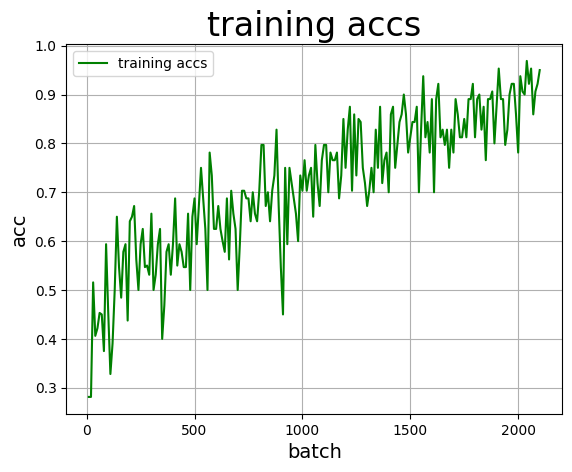

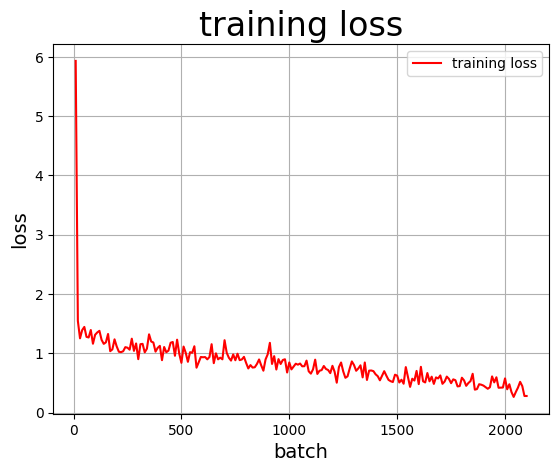

In [66]:
paddle.save(model.state_dict(),'MyCNN')#保存模型
draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

# **五、模型评估**

In [67]:
#模型评估
para_state_dict = paddle.load("MyCNN") 
model = MyCNN()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #验证模式

accs = []

for batch_id,data in enumerate(eval_loader()):#测试集
    image=data[0]
    label=data[1]     
    predict=model(image)       
    acc=paddle.metric.accuracy(predict,label)
    accs.append(acc.numpy()[0])
    avg_acc = np.mean(accs)
print("当前模型在验证集上的准确率为:",avg_acc)

C:\Users\12631\AppData\Local\Temp\ipykernel_13688\1672243589.py:41: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((64, 64), Image.BILINEAR)


当前模型在验证集上的准确率为: 0.48214287


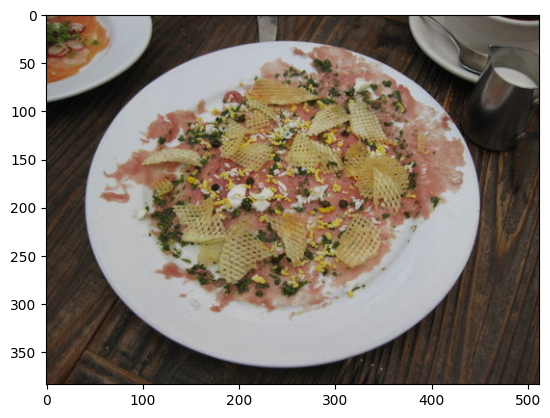

3
{'0': 'apple_pie', '1': 'baby_back_ribs', '2': 'baklava', '3': 'beef_carpaccio', '4': 'beef_tartare'}
data\foods\beef_carpaccio\11466.jpg
第1个样本,被预测为：beef_carpaccio,真实标签为：beef_carpaccio
结束


C:\Users\12631\AppData\Local\Temp\ipykernel_13688\3650947798.py:21: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((64, 64), Image.BILINEAR)


In [68]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path)):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((64, 64), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = 'data/foods.zip'
infer_dst_path = 'data/foods_test'
unzip_infer_data(infer_src_path,infer_dst_path)

'''
模型预测
'''

para_state_dict = paddle.load("MyCNN")
model = MyCNN()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #验证模式

#展示预测图片
infer_path=rf'data\foods\beef_carpaccio\11466.jpg'

img = Image.open(infer_path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像
#对预测图片进行预处理
infer_imgs = []
infer_imgs.append(load_image(infer_path))
infer_imgs = np.array(infer_imgs)
label_dic = train_parameters['label_dict']
for i in range(len(infer_imgs)):
    data = infer_imgs[i]
    dy_x_data = np.array(data).astype('float32')
    dy_x_data=dy_x_data[np.newaxis,:, : ,:]
    img = paddle.to_tensor (dy_x_data)
    out = model(img)
    lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
    print(lab)
    print(label_dic)
    print(infer_path)
    print("第{}个样本,被预测为：{},真实标签为：{}".format(i+1,label_dic[str(lab)],infer_path.split('\\')[-2]) )     
print("结束")

In [69]:
label_dic

{'0': 'apple_pie',
 '1': 'baby_back_ribs',
 '2': 'baklava',
 '3': 'beef_carpaccio',
 '4': 'beef_tartare'}

In [70]:
lab

3